In [108]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions
import matplotlib.collections as mcoll

In [2]:
class ShallowWaterEquationsIntegrator1D:
    def __init__(self, *, h_initial: np.ndarray, uh_initial: np.ndarray, bathymetry: np.ndarray, options: Options = None):
        """ initializes the solvers for a given initial condition of `h` and `uh`
        assuming constant inflow from right side """
        options = options or Options(nonoscillatory=True, infinite_gauge=True)
        grid = h_initial.shape 
        stepper = Stepper(options=options, grid=grid)
        
        kwargs = {
            'boundary_conditions': [boundary_conditions.Extrapolated()] * len(grid),
            'halo': options.n_halo,
        }
        
        advectees = {
            "h": ScalarField(h_initial, **kwargs),
            "uh": ScalarField(uh_initial, **kwargs),
        }
        
        self.advector = VectorField((
                np.zeros(grid[0] + 1),
            ), **kwargs
        )
        
        self.bathymetry = bathymetry
        self.solvers = { k: Solver(stepper, v, self.advector) for k, v in advectees.items() }

    def __getitem__(self, key):
        """ returns `key` advectee field of the current solver state """
        return self.solvers[key].advectee.get()
    
    def _apply_half_rhs(self, *, key, g_times_dt_over_dx):
        """ applies half of the source term in the x direction """
        self[key][:] -= .5 * g_times_dt_over_dx * self['h'] * np.gradient(self['h'] - self.bathymetry, axis=0)

    def _update_courant_numbers(self, *, key, mask, dt_over_dx):
        """ computes the Courant number component from fluid column height and momenta fields """
        velocity = np.where(mask, np.nan, 0)
        momentum = self[key]
        np.divide(momentum, self['h'], where=mask, out=velocity)

        all_but_last = slice(None, -1)
        all_but_first_and_last = slice(1, -1)

        velocity_at_cell_boundaries = velocity[all_but_last] + np.diff(velocity, axis=0) / 2 
        
        courant_number = self.advector.get_component(0)[all_but_first_and_last]
        
        courant_number[:] = velocity_at_cell_boundaries * dt_over_dx
        assert np.amax(np.abs(courant_number)) <= 1

    def __call__(self, *, nt: int, g: float, dt_over_dx: float, outfreq: int, eps: float=1e-7):
        output = {k: [] for k in self.solvers.keys()}
        
        # initial values fromm right side 
        # (constant inflow)
        inflow_h = self['h'][-1]
        inflow_uh = self['uh'][-1] 

        for it in range(nt + 1): 
            if it != 0:
                
                ### Boundries definitions ###

                # Left side - copying from [1]
                # Let water outflow
                self['h'][0] = self['h'][1]
                self['uh'][0] = self['uh'][1]

                # Right side - constant value
                # Inflow is not changing
                self['h'][-1] = inflow_h
                self['uh'][-1] = inflow_uh

                mask = self['h'] > eps
                
                self._update_courant_numbers(key="uh", mask=mask, dt_over_dx=dt_over_dx)
                self.solvers["h"].advance(n_steps=1)
                
                self['h'][0] = self['h'][1]
                self['h'][-1] = inflow_h

                self._apply_half_rhs(key="uh", g_times_dt_over_dx=g * dt_over_dx)
                self.solvers["uh"].advance(n_steps=1)
                self._apply_half_rhs(key="uh", g_times_dt_over_dx=g * dt_over_dx)

                self['uh'][0] = self['uh'][1]
                self['uh'][-1] = inflow_uh

            if it % outfreq == 0:
                for key in self.solvers.keys():
                    output[key].append(self[key].copy())
                    
        return output

In [ ]:
def generate_bathymetry(shape_type, grid_len, height, center, width):
    """
    1D bathymetry generator.
    shape_type: 'gaussian', 'flat'
    parameters: height, center, width
    """
    # base bathymetry
    b = np.zeros(grid_len) 
    
    x = np.arange(grid_len)
    
        
    if shape_type == 'gaussian':
        sigma = width / 2
        b -= height * np.exp(-((x - center)**2) / (2 * sigma**2))
        b += height
          
    return b

In [192]:
t = 1000       #s
dt = 0.04  #s
dx = 0.5    #m

In [193]:
def generate_output(obs_height, width, bathymetry='gaussian'):
    """
    Function that generate output using ShallowWaterEquationsIntegrator1D
    with given obs_height and width (type: 'gaussian')
    """
    grid_len = int(200 / dx)
    h_depth = 2.0   # m
    b = generate_bathymetry(
            shape_type=bathymetry, 
            grid_len=grid_len, 
            height=obs_height, 
            center=int(100 / dx), 
            width= int(width/dx)
        )   
    
    h_initial = b.copy() + h_depth - obs_height
    velocity = -1.  # m/s
    uh_initial = h_initial * velocity

    return (ShallowWaterEquationsIntegrator1D(
            h_initial=h_initial, 
            uh_initial=uh_initial,
            bathymetry=b
        )(
            nt=int(t/dt), 
            g=10, 
            dt_over_dx=dt/dx,
            outfreq=100
        )), b

In [ ]:
outputs = []
bathy = []
heights = np.array([0.25, 0.5, 0.75, 1.0, 1.25, 1.5])
width = 10 

for i in range(6):
    out, b = generate_output(heights[i], width)
    outputs.append(out)
    bathy.append(b)
    # print(heights[i])

0.25
0.5
0.75
1.0
1.25
1.5


In [ ]:
# def plot(frame, *, zlim=(-0.1, 2.25)):
#     b = bathy[0]
#     psi = outputs[0]['h'][frame] - b + np.max(b)
    
#     x = np.arange(len(psi))
    
#     fig, ax = pyplot.subplots(figsize=(12, 6))
    
#     # bathymetry
#     ax.fill_between(x[:-5], zlim[0], np.max(b) - b[:-5], color='dimgray', alpha=0.5, label='Dno (b)')
#     ax.plot(x[:-5], np.max(b) - b[:-5], color='black', linewidth=1)

#     # Water
#     ax.fill_between(x[:-5], np.max(b) - b[:-5], psi[:-5], color='deepskyblue', alpha=0.3, label='Woda')
#     ax.plot(x[:-5], psi[:-5], color='blue', linewidth=1.5)

#     ax.set(
#         ylim=zlim, 
#         xlim=(0, len(psi[:-5])),
#         title=f"t / Δt = {frame}", 
#         # ylabel=r"Wysokość ($\zeta$)",
#         ylabel=r"Wysokość",
#         xlabel="x / Δx"
#     )
    
#     ax.grid(True, linestyle=':', alpha=0.6)
#     ax.legend(loc='upper right')

#     return fig

# show_anim(plot, range(len(outputs2[0]['h'])))

In [346]:
def plot_colored_line(out, b, frame, case):
    """
    Function that plot 'u' as collor of line on 'h' plot
    """
    h = out['h'][frame]
    uh = out['uh'][frame]
    surface = h - b + np.max(b)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        u = np.where(h > 1e-4, uh / h, 0.0)
    
    x = np.linspace(0, 200-dx, len(h))
    
    fig, ax = pyplot.subplots(figsize=(10, 5))
    
    ax.fill_between(x, 0, np.max(b) - b, color='gray', alpha=0.5)
    ax.plot(x, np.max(b) - b, 'k', linewidth=1)
    
    ax.fill_between(x, np.max(b) - b, surface, color='lightblue', alpha=0.3)
    
    points = np.array([x, surface]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    

    lc = mcoll.LineCollection(segments, cmap='turbo', linewidth=2.5)
    lc.set_array(u)

    ax.add_collection(lc)
    
    
    cbar = pyplot.colorbar(lc, ax=ax)
    cbar.set_label('Prędkość u [m/s]')
    
    ax.set_ylim(0, np.max(b) + 2.0)
    ax.set_xlim(0, np.max(x) - 10)
    ax.set_xlabel('x [m]', fontsize=10)
    ax.set_ylabel('wysokość [m]', fontsize=10)
    
    if case ==1:
        ax.set_title(f"Rysunek 1. Wysokość oraz prędkość w chwili początkowej (t={frame}s) dla wysokości h=1.5m\n", fontsize=16)
        show_plot("rys1.pdf")
    else:
        ax.set_title(f"Rysunek 5. Wysokość oraz prędkość dla dwa razy większego dt oraz dx\ndla wysokości h=1.5m (t=10000s)\n", fontsize=16)
        show_plot("rys5.pdf")

In [176]:
# plot_colored_line(outputs[0], bathy[0], -1)

In [296]:
def plot_all_cases(outputs_list, bathymetries_list, frame):
    """
    Function that plot 'u' as collor of line on 'h' plot for all outputs
    """
    
    rows, cols = 3, 2
    fig, axes = pyplot.subplots(rows, cols, figsize=(18, 12), constrained_layout=True)
    
    
    axes_flat = axes.flatten()
    
    
    for i, ax in enumerate(axes_flat):
        
        if i >= len(outputs_list):
            ax.axis('off')
            continue
            
        
        out = outputs_list[i]
        b = bathymetries_list[i]
        
        h = out['h'][frame]
        uh = out['uh'][frame]

        surface = h - b + np.max(b)
        
        # Prędkość u = uh / h
        with np.errstate(divide='ignore', invalid='ignore'):
            u = np.where(h > 1e-4, uh / h, 0.0)
            
        x = np.linspace(0, len(h)*dx - dx, len(h))
        

        bed_profile = np.max(b) - b
        ax.fill_between(x, 0, bed_profile, color='gray', alpha=0.5)
        ax.plot(x, bed_profile, 'k', linewidth=1)
        
        ax.fill_between(x, bed_profile, surface, color='lightblue', alpha=0.3)
        
        points = np.array([x, surface]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        

        norm = pyplot.Normalize(vmin=-7.0, vmax=0) 
        
        lc = mcoll.LineCollection(segments, cmap='turbo', norm=norm, linewidth=2.5)
        lc.set_array(u)
        ax.add_collection(lc)
        
        ax.set_xlabel('x [m]', fontsize=10)
        ax.set_ylabel('wysokość [m]', fontsize=10)
        ax.set_ylim(0, np.max(b) + 3.0) 
        ax.set_xlim(0, np.max(x)-10)
        
        ax.set_title(f"\nWysokość progu: {heights[i]}m", fontsize=12)
        ax.grid(True, linestyle=':', alpha=0.6)
        
        cbar = fig.colorbar(lc, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('u [m/s]', fontsize=10)

    fig.suptitle(f"Rysunek 2. Zestawienie wyników symulacji - wysokości oraz prędkości (t = 1000s)\n", fontsize=16)
    show_plot("profil_u.pdf")

In [189]:
# plot_all_cases(outputs, bathy, -1)

In [335]:
def calc_h_ratio(out, b, i):
    h = out['h'][-1]
    uh = out['uh'][-1]
    surface = h - b + np.max(b)

    h_len = len(h)

    h_bef = h[int(3/4*h_len)]
    h_aft = h[int(1/4*h_len)]
    h_on = h[int(1/2*h_len)] + heights[i]

    u_bef = abs(uh[int(3/4*h_len)] / h[int(3/4*h_len)])
    u_aft = abs(uh[int(1/4*h_len)] / h[int(1/4*h_len)])
    u_on = abs(uh[int(1/2*h_len)] / h[int(1/2*h_len)])

    return (h_bef - h_aft)/h_bef, (h_bef - h_on)/h_bef, u_bef, u_aft, u_on

In [336]:
h_ratios = np.zeros(len(heights))
h_100 = np.zeros(len(heights))

u_bef = np.zeros(len(heights))
u_aft = np.zeros(len(heights))
u_on = np.zeros(len(heights))

for i in range(len(heights)):
    h_ratios[i], h_100[i], u_bef[i], u_aft[i], u_on[i] = calc_h_ratio(outputs[i], bathy[i], i)

In [ ]:
def plot_results():
    pyplot.figure(figsize=(20,6))
    pyplot.subplot(1,2,1)
    pyplot.plot(heights, h_100*100, 'o-', label='nad progiem (x=100m)')
    pyplot.plot(heights, h_ratios*100, 'o-', label='za progiem (x=50m)')

    pyplot.xlabel("Wysokość progu wodnego [m]", fontsize=10)
    pyplot.title("Rysunek 3. Zalezność względnego spadku poziomu wody\nod wysokości progu (względem h dla x=150m)\n", fontsize=16)
    pyplot.ylabel("Względny spadek głębokości [%]", fontsize=10)
    pyplot.grid()
    pyplot.legend(fontsize = 10, loc='center left')

    pyplot.subplot(1,2,2)

    pyplot.plot(heights, u_bef, 'o-', label='przed progiem (x=150m)')
    pyplot.plot(heights, u_on, 'o-', label='nad progiem (x=100m)')
    pyplot.plot(heights, u_aft, 'o-', label='za progiem (x=50m)')
    # pyplot.yscale('log')
    pyplot.xlabel("Wysokość progu wodnego [m]", fontsize=10)
    pyplot.title("Rysunek 4. Zalezność prędkości wody od wysokości progu\n(przed, na oraz za progiem)\n", fontsize=16)
    pyplot.ylabel("|u| [m/s]", fontsize=10)
    pyplot.grid()
    pyplot.legend(fontsize = 10, loc='center left')

    pyplot.tight_layout()
    show_plot(f'wyniki.pdf')

In [330]:
# plot_results2()

In [202]:
dt *= 2
dx *= 2
out22, b22 = generate_output(1.5, width)
dt /= 2
dx /= 2

In [294]:
def check_stability(out1, out2, dx):
    vol = np.sum(out1['h'][-1][0:-20]) * dx
    vol2 = np.sum(out2['h'][-1][0:-10]) * dx*2
    print("Objętości podane bez ostatnich 10m z racji na sztywny warunek brzegowy")
    print(f"Objetosc dla dx, dt:     {vol:.4f} m^3")
    print(f"Objetosc dla 2dx i 2dt:  {vol2:.4f} m^3")
    print(f"Względna różnica symulacji [dx, dt] oraz [2dx, 2dt] do [dx, dt]: {abs(vol - vol2)/vol*100:.4f} %")
    

Michał Hubczak

# Pytanie: Jak wysokość przeszkody na dnie rzeki wpływa na jej głębokość?

Celem projektu było przeprowadzenie symualcji przepływu rzeki z progiem wodnym. Rozważany kształt progu to gaussian, z racji na brak nagłych skoków, a tym samym niewelowane są dodatkowe potencjalne błędy numerycznych. 

Symulacja prowadzona była dla następujących parametrów:

- <b>czas</b>: $t = 1000s$ natomiast $dt = 0.04s$

- <b>długość rzeki</b>: $x = 200m$ natomiast $dx = 0.5m$

- <b>położenie progu</b>: $srodek=100m$ natomiast $szerokosc: 10m$ (szerokość to $\sigma$ dla gaussianu)

- <b>badane wysokości progu</b>: 0.25m, 0.5m, 0.75m, 1m, 1.25m, 1.5m

- <b>początkowa głębokość wody</b>: 2m

- <b>prędkość wody</b>: -1m/s (rzeka płynie w lewo)


Ustalony czas $1000s$ podyktowany był wcześniejszymi próbami różnych długości trwania symualcji, dla których wynik końcowy nie był ustalony. Wybrany czas gwarantował stabilny wynik dla wszystkich wartości progu. Dla analizy wyników symulacji jedną istotną chwilą była ostatnia - początkowe założenie płaskiej tafli wody powoduje, ze głównym powodem długiego czasu symualcji jest potrzebny czas do ustalenia się stabilnego stanu - stąd końcowe wyniki mogą mieć różną głębokość niz początkowa. Z tego powodu parametrem słuzącym do zbadania wpływu progu na rzekę, będzie procentowa względna zmiana  wysokości (przed vs za oraz na_progu vs za):

$$\Delta H_{za} = \frac{ h_{przed} - h_{za}}{h_{przed}} \ \ \ \  \Delta H_{prog} = \frac{ h_{przed} - h_{prog}}{h_{przed}}$$

Położenia owych miejsc to 50m (za), 100m (na) oraz 150m (przed).

Z powodu bardzo długiego czasu oczekiwania na ustalenie się powierzchni, symualcja była prowadzona dla przepływu jednowymiarowego (tylko 'uh'). 

Poniższy wykres (Rysunek 1.) przedstawia początkowa wysokość i prędkość dla przykładowego progu - pozostałe wyglądają analogicznie.

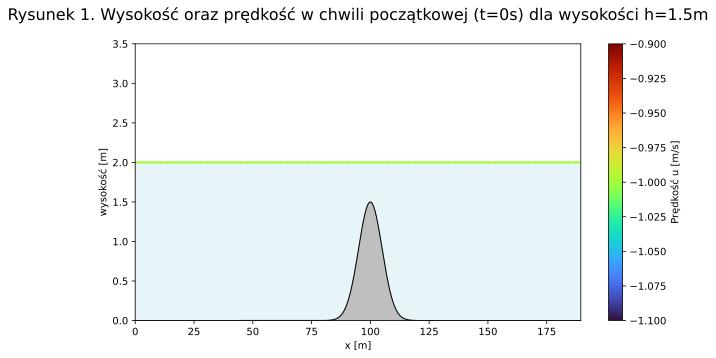

In [347]:
plot_colored_line(outputs[5], bathy[5], 0, 1)

Na Rysunku 1. widzimy poziomą taflę wody, kolor lini reprezentuje prędkość danego słupa cieczy - w tym wypadku całość ma na początku tą samą predkość ($-1m/s$). Na środku widoczne jest wybrzuszenie reprezentujace próg wodny. Zgodnie z wcześniejszymi założeniami, znajduje się on w środku (100m), a jego szerokość ($\sigma$) wynosi 10m. Warto zwrócić uwagę również na oś OX gdzie pomimo wykonywania symulacji dla 200m odcinka rzeki widzimy jedynie około 190m - spowodowane jest to trudnościami w implementacji odpowiedniego warunku brzegowego (na stałe woda wypływa z wysokością 2m) - w celu uniknięcia rysowania niefizycznej sytuacji przy obniżeniu lub podwyższeniu tafli ucinamy kilka ostatnich elementów.

Po wykonanej symulacji dla poszczególnych wysokości progów wykresy przedstawiaja się nastepująco (Rysunek 2.).

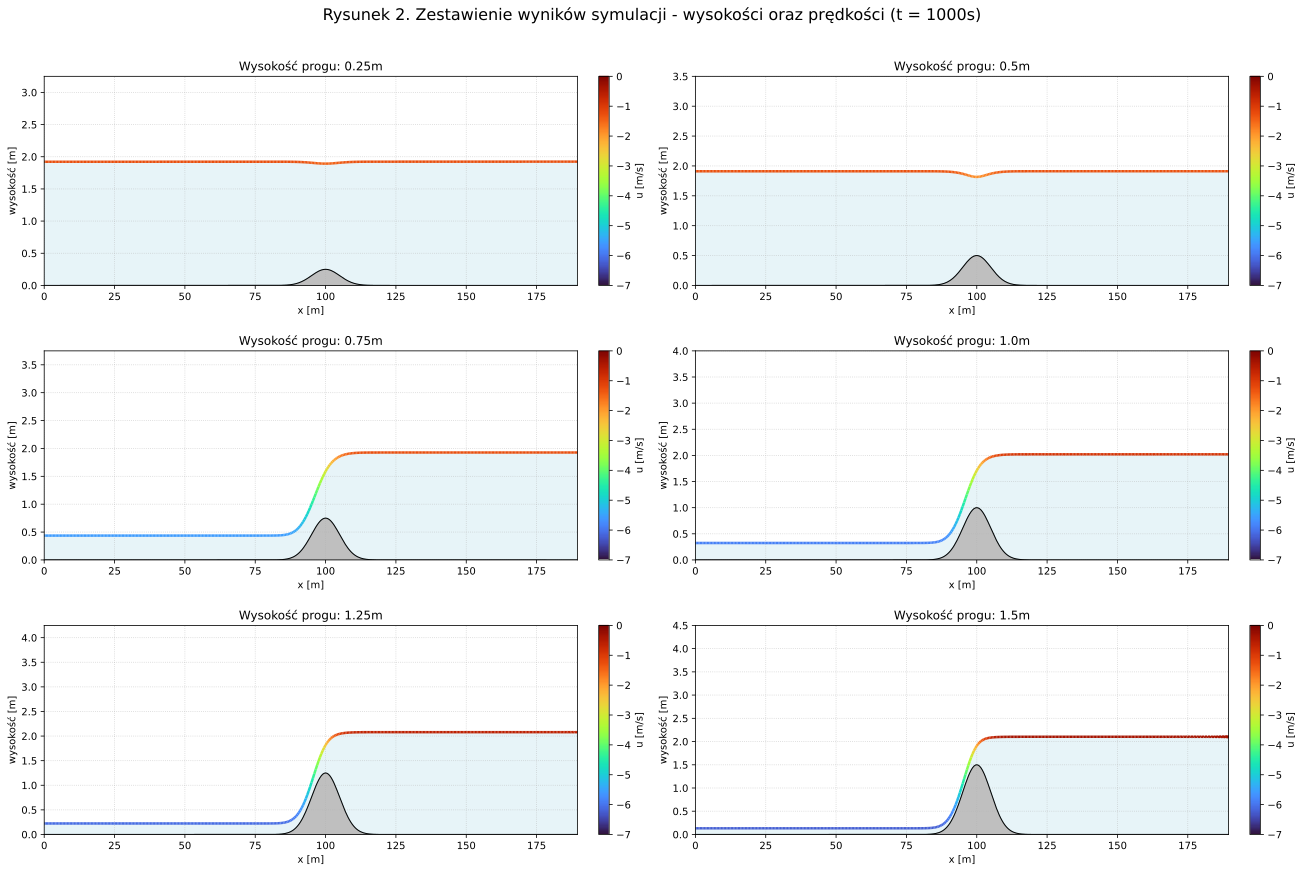

In [342]:
plot_all_cases(outputs, bathy, -1)

Widzimy, że od wysokości progu=0.75m głębokość rzeki za progiem zmienia się znacznie bardziej. Rzeka istotnie zwiększa swoją prędkość. Dla mniejszych wartości obserwujemy niewielkie wgłębienie w tafli w miejscu odpowiadającemu progowi. Nie jest obserwowana widoczna zmiana prędkości rzeki za progiem, natomiast na nim widzimy lekkie przyspieszenie.

<b>Dla mniejszych progów</b> widzimy efekt wnęki - podniesienie się dna powoduje zmniejszenie miejsca dla wody, w zwiazku z tym woda przespiesza. Zatem z prawa Bernuliego ciśnienie spada co powoduje nieznaczne obniżenie poziomu rzeki.

<b>Dla większych wysokości progu</b> woda ma za mało energi, żeby przepłynąc przez próg w związku z czym zaczyna się spiętrzać. Po przejściu przez próg zgromadzona energia zamienia się w energię kinetyczną (czyli predkość) co powoduje gwałtowne przyspieszenie i spływanie jak po tamie. 

Poniższe wykresy (Rysunek 3. oraz Rysunek 4.) przedstawiają zależność względnego spadku poziomu wody od wysokosci progu (poziom wody oznacza wysokość tafli względem wysokości $0$ - w konsekwencji przy podawaniu wysokości nad progiem dodana jest jego wysokość) oraz zależność prędkości od wysokości progu w różnych miejscach (50m, 100m, 150m).

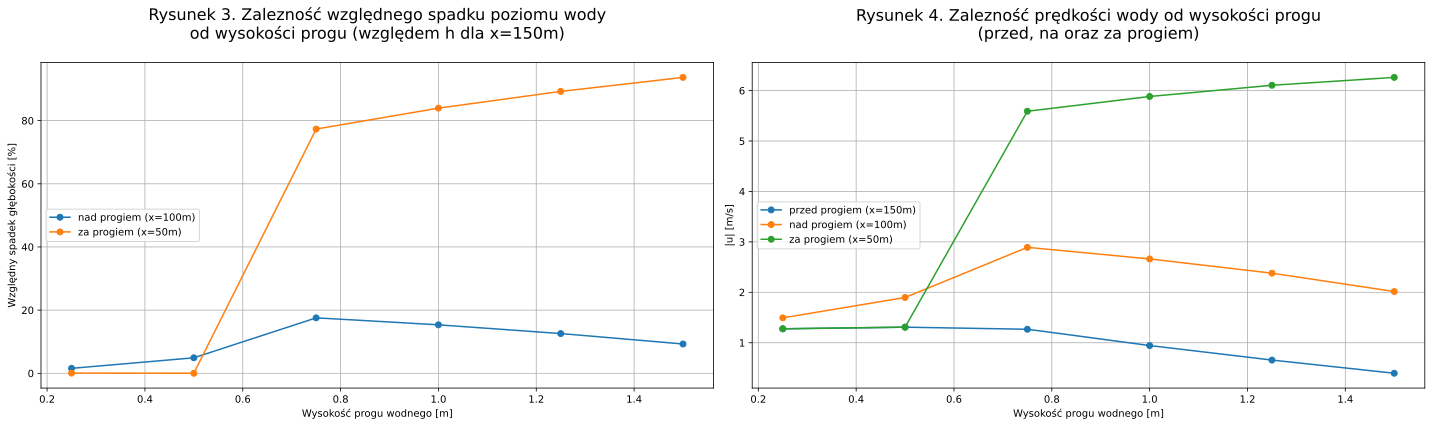

In [345]:
plot_results()

Powyższy wykres względnego spadku (Rysunek 3.) pokazuje, że w przypadku zastosowanych tutaj wysokości progów jest albo znaczna $\sim80\%$, albo bliska $0\%$. Natomaist wysokość wody na progu już zmienia się w każdym przypadku. Sytuacje gdy mamy do czynienia z niewielkim spadkiem wysokości wody, może służyć na przykład do wykrywania niewelkich nierówności podczas spływu kajakiem. W przypadku większych progów zauważyć bedzie je łatwiej z powodu znacznego spadku poziomu rzeki za progiem.

Natomiast na wykresie zależności prędkości (Rysunek 4.) widzimy, że zgodnie z wcześniejszymi wykresami dla niskich progów (<0.75m) mamy brak zmiany w predkości za przeszkodą względem prędkości przed nią. Wzrostowi ulega prędkość na przeszkodzie (większa dla większego progu). Dla wyższych przeszkód obserwujemy przyspieszenie na niej oraz znaczne przyspieszenie za nią względem prędkości przed. Dla większych progów otrzymujemy większą wartość prędkości za nim, natomiast prędkości na progu i przed nim maleją dla coraz większych wysokości przeszkody.

W celu sprawdzenia stabilność porównanie zostało pole pod wykresami w ostatnich chwili czasowej dla 2 razy wiekszego dt i dx, dla progu 1.5m z racji na bardzo długi czas trwania symualcji

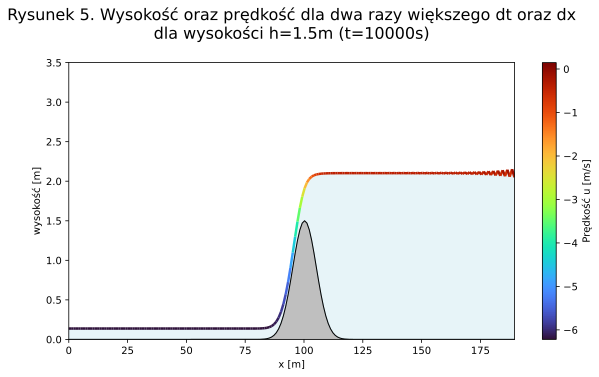

In [348]:
plot_colored_line(out22, b22, -1, 0)

In [295]:
check_stability(outputs[-1], out22, dx)

Objętości podane bez ostatnich 10m z racji na sztywny warunek brzegowy
Objetosc dla dx, dt:     193.0013 m^3
Objetosc dla 2dx i 2dt:  192.9189 m^3
Względna różnica symulacji [dx, dt] oraz [2dx, 2dt] do [dx, dt]: 0.0427 %


Z powyższej symulacji i porównania wynika, że dwukrotne zwiększenie kroku przestrzennego oraz czasowego nie powoduje istotnej zmiany w kształcie krzywej - wzgledna różnica pola pod wykresami jest niewielkim ułamkiem procenta. Na Rysunku 5. widzimy analogiczny wykres do tego dla mniejszego dt i dx, jedyna różnica dodyczy dużej utrzymujących się zafalowań związanych z wcześniej wspomnianymi definicjami brzegów. Jednak dla tej analizy nie ma to istotnej roli, ponieważ ostatecznie jest obserwowany ten sam efekt.